In [551]:
#numpy and pandas
import numpy as np
import random as r

#graphing imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics

#jupyter-lab configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import import_ipynb

#config imports
import warnings; warnings.simplefilter('ignore')

#models
from scipy import stats as st
from scipy import optimize

Recall that, mean given variance has the full conditional
$
\begin{align}
P(\mu | \sigma^2,y_1,..,y_n) \propto N(\frac{\frac{n\bar{y}}{\sigma^2} + \frac{\mu_0}{\sigma^2_0}}{\frac{n/\sigma^2}{1/\sigma_0^2}},\frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma^2_0}})
\end{align}$

and the variance given mean has the full conditional

$
\\
\begin{align} 
P(\sigma^2 | \mu,y_1,..,y_n) \propto IG(\nu_0 + \frac{n}{2}, \beta_0 + \frac{\Sigma_{i=1}^n(y_i - \mu)^2}{2}) 
\end{align} $

In the functions, we are essentially implementing these formulas

In [797]:
def update_mu(n_samples, y_bar, sigma2, mu_0, sigma2_0):
    """function to update mu
        Parameters
        ----------
        n_samples : int
            number of samples of data that we are given
        y_bar : int
            mean of the data
        sigma2: int
            current accepted variance of the gibbs sampler
        mu_0: int
            hyper parameter of mean of the prior mean
        sigma2_0: int
            hyper parameter of variance of the prior mean
            
        Returns
        ----------
        sampled_mean: int
            new updated value of mean
    """
    new_sigma = 1/((n_samples/sigma2)+(1/sigma2_0))
    new_mean = new_sigma * ((n_samples * y_bar/sigma2) + (mu_0/sigma2_0))
    sampled_mean = np.random.normal(new_mean, np.sqrt(new_sigma))
    return sampled_mean

In [712]:
def update_sig2(n_samples, y, mu, nu_0, beta_0):
    """function to update mu
        Parameters
        ----------
        n_samples : int
            number of samples of data that we are given
        y : list[]
            data
        mu: int
            current accepted mean of the gibbs sampler
        nu_0: int
            hyper parameter of mean of the prior variance
        sigma2_0: int
            hyper parameter of variance of the prior variance
            
        Returns
        ----------
        sampled_variance: int
            new updated value of variance
    """
    new_alpha = nu_0 + n_samples / 2
    new_beta = beta_0 + (sum([(i-mu)**2 for i in y])/2)
    sampled_variance = 1 / np.random.gamma(new_alpha, 1/new_beta)

    return sampled_variance

In [634]:
def gibbs_sampler(y, num_iter, prior):
    """function to update mu
        Parameters
        ----------
        y : list[]
            data
        num_iter: int
            number of iterations of the gibbs sampler
        prior: dict
            dictionary containing hyper parameters of the mean and variance
            
        Returns
        ----------
        mu: int
            mean returned from the gibbs sampler
        sig2: int
            variance returned from the gibbs sampler
    """
    y_bar = np.mean(y)
    n_samples = len(y)
    
    #initialize empty lists for mu and sigmas
    mu = []
    sig2 = []
    
    #initializing mu so we can sample sigma
    mu_current = 0
    
    #sampling means and variances from the functions described above
    for i in range(num_iter):
        sig2_current = update_sig2(n_samples, y, mu_current, prior['nu_0'], prior['beta_0'])
        mu_current = update_mu(n_samples, y_bar, sig2_current, prior['mu_0'], prior['sig2_0'])
        
        sig2.append(sig2_current)
        mu.append(mu_current)
        
    return mu,sig2
        

In [793]:
r.seed(35)
y = list(np.random.normal(2,1,10))
y_bar = np.mean(y)

## prior
prior = {}
prior['mu_0'] = 0.0
prior['sig2_0'] = 1.0
prior['nu_0'] = 1 # prior alpha for inverse-gamma
prior['beta_0'] = 1 # prior beta for inverse-gamma

posterior = gibbs_sampler(y, 1000, prior)

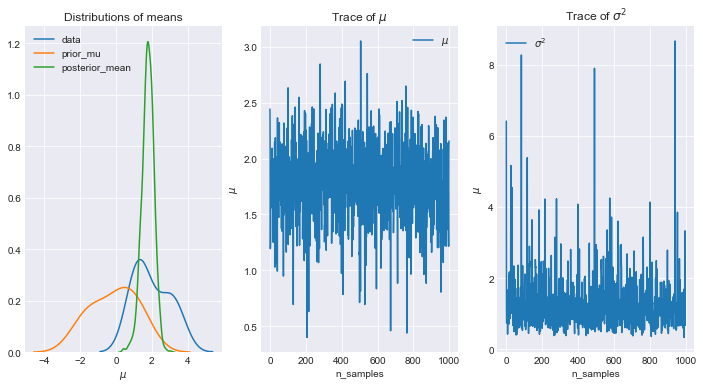

In [798]:
fig, axes = plt.subplots(1,3, figsize = (12,6))
sns.kdeplot(y,label='data',ax=axes[0])
sns.kdeplot(prior_mu, label='prior_mu',ax=axes[0])
posterior_mean=posterior[0]
sns.kdeplot(posterior_mean, label='posterior_mean', ax=axes[0])
axes[0].set_title('Distributions of means')
axes[0].set_xlabel('$\mu$')

axes[1].plot(posterior[0],label='$\mu$')
axes[1].legend()
axes[1].set_title('Trace of $\mu$')
axes[1].set_xlabel('n_samples')
axes[1].set_ylabel('$\mu$')


axes[2].plot(posterior[1],label='$\sigma^2$')
axes[2].legend()
axes[2].set_title('Trace of $\sigma^2$')
axes[2].set_xlabel('n_samples')
axes[2].set_ylabel('$\mu$')
fig.savefig('gibbs_result.png');
